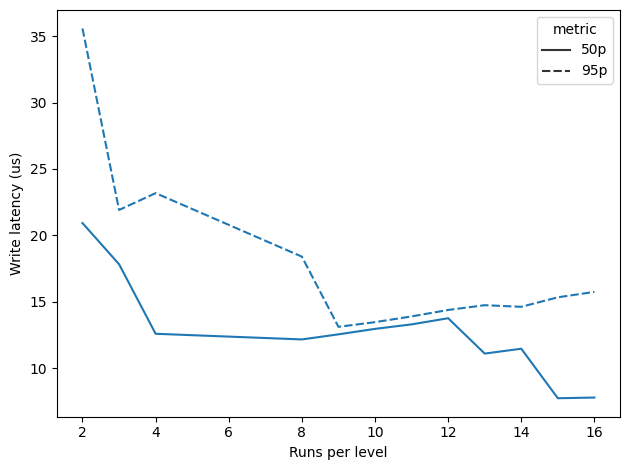

In [4]:
# max runs per level, writes

from numpy import percentile

from utils import run
from distributions import Uniform, Zipfian
from kevo import LSMTree, AppendLog, HybridLog, MemOnly, PathRemote

from pygav.data import lineplot, barplot, relplot
from pygav.utils import Timer

from utils import run


def measure_max_runs_per_level(db, distro, keys_set, vals_set, n_ops, engine, eng_comb, **args):
    res = []

    seconds = 10
    writes_per_sec = 10_000

    latencies = []
    for i in range(seconds):
        # pick key/values to write
        with Timer() as latency:
            for _ in range(writes_per_sec):
                db[keys_set[next(distro)]] = vals_set[next(distro)]
        latency = float(latency)
        avg_latency = latency / writes_per_sec
        # if latency < 1:
        #     sleep(1 - latency)
        latencies.append(avg_latency)

    res.append({'metric': '50p', 'value': percentile(latencies, 50)})
    res.append({'metric': '95p', 'value': percentile(latencies, 95)})

    return res


df = run(
    [4], [4], [10_000], [0],
    [Uniform], [{'seed': [1]}],
    [LSMTree], [{
        'max_runs_per_level': [2, 3, 4, 8, 9, 10, 11, 12, 13, 14, 15, 16],
        'density_factor': [10],
        'memtable_bytes_limit': [10_000],
        'remote': [None]
    }],
    [measure_max_runs_per_level], {}
)


data = df[['max_runs_per_level', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['50p', '95p'])]
data['value'] = data['value'] * 1000000   #us

lineplot(data=data, x='max_runs_per_level', y='value', style='metric', filename='max_runs_per_level_write.pdf', xlabel='Runs per level', ylabel='Write latency (us)')

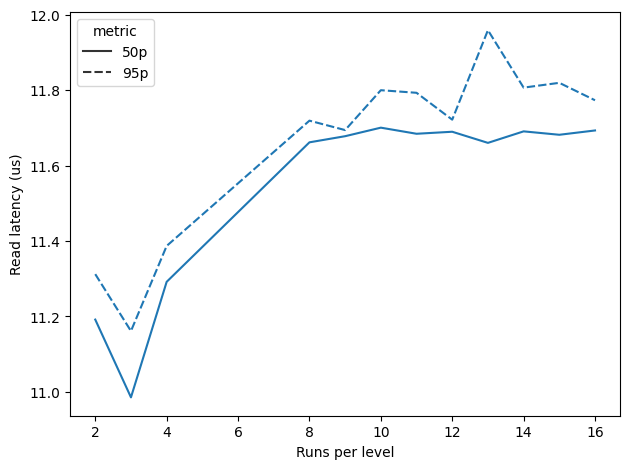

In [3]:
from numpy import percentile

from utils import run
from distributions import Uniform, Zipfian
from kevo import LSMTree, AppendLog, HybridLog, MemOnly, PathRemote

from pygav.data import lineplot, barplot, relplot
from pygav.utils import Timer

from utils import run


def measure_memtable_bytes_limit(db, distro, keys_set, vals_set, n_ops, engine, eng_comb, **args):
    res = []

    seconds = 10
    reads_per_sec = 10_000
    
    # populate first
    for k, v in zip(keys_set, vals_set):
        db[k] = v

    latencies = []
    for i in range(seconds):
        # pick key/values to write
        with Timer() as latency:
            for _ in range(reads_per_sec):
                _ = db[keys_set[next(distro)]]
        latency = float(latency)
        avg_latency = latency / reads_per_sec
        # if latency < 1:
        #     sleep(1 - latency)
        latencies.append(avg_latency)

    res.append({'metric': '50p', 'value': percentile(latencies, 50)})
    res.append({'metric': '95p', 'value': percentile(latencies, 95)})

    return res


df = run(
    [4], [4], [10_000], [0],
    [Uniform], [{'seed': [1]}],
    [LSMTree], [{
        'max_runs_per_level': [2, 3, 4, 8, 9, 10, 11, 12, 13, 14, 15, 16],
        'density_factor': [10],
        'memtable_bytes_limit': [10_000],
        'remote': [None]
    }],
    [measure_memtable_bytes_limit], {}
)

data = df[['max_runs_per_level', 'metric', 'value', 'engine']]
data = data[data['metric'].isin(['50p', '95p'])]
data['value'] = data['value'] * 1000000   #us

lineplot(data=data, x='max_runs_per_level', y='value', style='metric', filename='max_runs_per_level_read.pdf', xlabel='Runs per level', ylabel='Read latency (us)')